## M1 - Model prediksi titik panas di Sumatera Selatan 2001 - 2023

In [1]:
# load all functions
from C01_data_collection import *
from C02_visualization import *
from C03_preprocessing import *
from C04_model_predictions import *
from C05_model_evaluate import *

- config models

In [2]:
# set random number
import random as rm
rm.seed(1234)

# set random number
import numpy as np
np.random.seed(1234)

# set random number
import tensorflow as tf
tf.random.set_seed(1234)

### 1. Akuisisi Data

In [3]:
# load dataset
dataset = data_hotspot("dataset_enso.csv")
print(dataset.tail())

      acq_date  hotspot  sst_anom  oni_anom  soi_anom
271 2023-08-31      186      1.30      1.32      -1.4
272 2023-09-30     2247      1.53      1.56      -2.1
273 2023-10-31     3200      1.59      1.78      -0.8
274 2023-11-30      390      1.90      1.92      -1.3
275 2023-12-31       42      1.99      1.97      -0.4


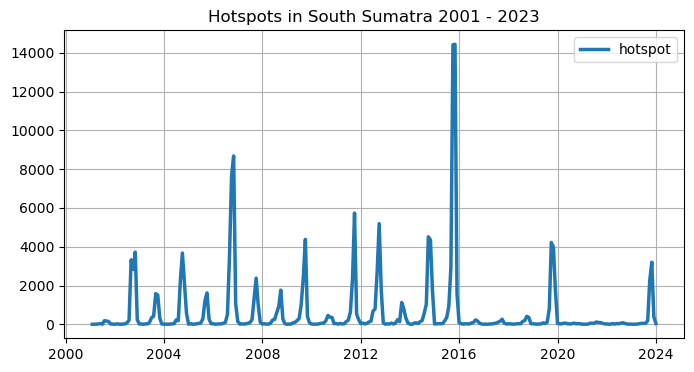

In [4]:
# hasil load dataset
lineplot1(x=dataset["acq_date"], y=dataset["hotspot"], label="hotspot", title="Hotspots in South Sumatra 2001 - 2023")

### 2. Praproses Data

In [5]:
# proses normalisasi min-max
scaler, scaled = normalized(dataset, ["hotspot"])

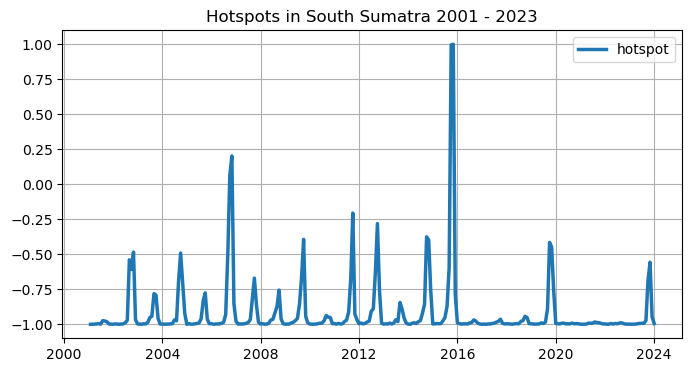

In [6]:
# hasil normalisasi min-max
lineplot1(x=dataset["acq_date"], y=scaled, label="hotspot", title="Hotspots in South Sumatra 2001 - 2023")

### 3. Pembagian Data

In [7]:
# proses pembagian data
train_data, test_data = splitting(scaled)
print(train_data.shape, test_data.shape)

(216, 1) (60, 1)


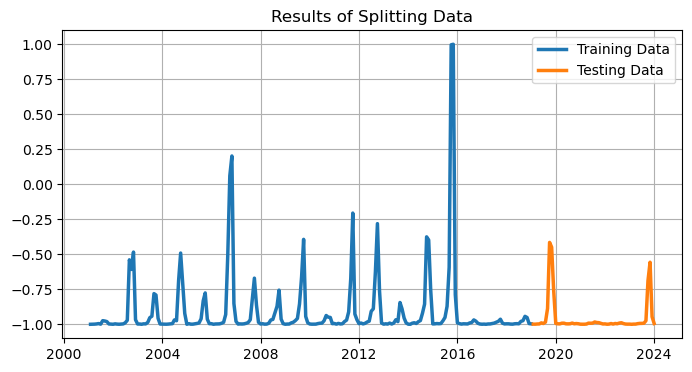

In [8]:
# hasil pembagian data
lineplot2(
  x1=dataset["acq_date"].iloc[:len(train_data)], y1= train_data, label1="Training Data",
  x2=dataset["acq_date"].iloc[len(train_data):], y2=test_data, label2="Testing Data",
  title="Results of Splitting Data"
)

### 4. Supervised Learning

In [9]:
# hasil supervised learning
x_train, y_train, x_test, y_test = results_univariate_supervised(train_data, test_data)

In [10]:
# cek dimensi data
print(x_train.shape, y_train.shape)

(215, 1, 1) (215,)


In [11]:
# cek dimensi data
print(x_test.shape, y_test.shape)

(59, 1, 1) (59,)


### 5. Algoritma LSTM-RNN

#### 5.1 SBi-LSTM-RNN

In [12]:
# call models LSTM
# param : algorithm, timestep, activation, optimizer, dropout
lstm_model = get_models_univariate(
  algorithm="SBi-LSTM", timestep=x_train, activation="selu", optimizer="sgd", dropout=0.25
)

In [13]:
# compile models
# param : model, batch_size, epochs, x_train, y_train, x_test, y_test
lstm_history, lstm_predictions = get_prediction(
  model=lstm_model, batch_size=8, epochs=1500, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

Epoch 1/1500
27/27 [==============================] - 7s 41ms/step - loss: 0.6960 - val_loss: 0.4835
Epoch 2/1500
27/27 [==============================] - 0s 6ms/step - loss: 0.3020 - val_loss: 0.0962
Epoch 3/1500
27/27 [==============================] - 0s 4ms/step - loss: 0.1082 - val_loss: 0.0376
Epoch 4/1500
27/27 [==============================] - 0s 5ms/step - loss: 0.1092 - val_loss: 0.0451
Epoch 5/1500
27/27 [==============================] - 0s 4ms/step - loss: 0.1039 - val_loss: 0.0437
Epoch 6/1500
27/27 [==============================] - 0s 4ms/step - loss: 0.1045 - val_loss: 0.0408
Epoch 7/1500
27/27 [==============================] - 0s 4ms/step - loss: 0.1045 - val_loss: 0.0386
Epoch 8/1500
27/27 [==============================] - 0s 4ms/step - loss: 0.1029 - val_loss: 0.0386
Epoch 9/1500
27/27 [==============================] - 0s 4ms/step - loss: 0.1005 - val_loss: 0.0394
Epoch 10/1500
27/27 [==============================] - 0s 4ms/step - loss: 0.1031 - val_loss: 0.037

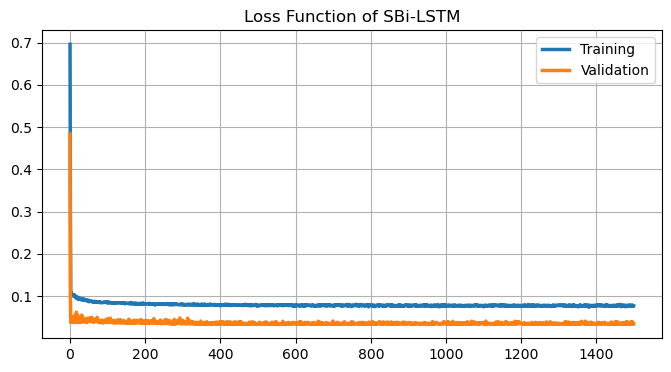

In [14]:
# show loss function
lineplot2(
  x1=lstm_history.epoch, y1=lstm_history.history['loss'], label1="Training",
  x2=lstm_history.epoch, y2=lstm_history.history['val_loss'], label2="Validation",
  title="Loss Function of SBi-LSTM"
)

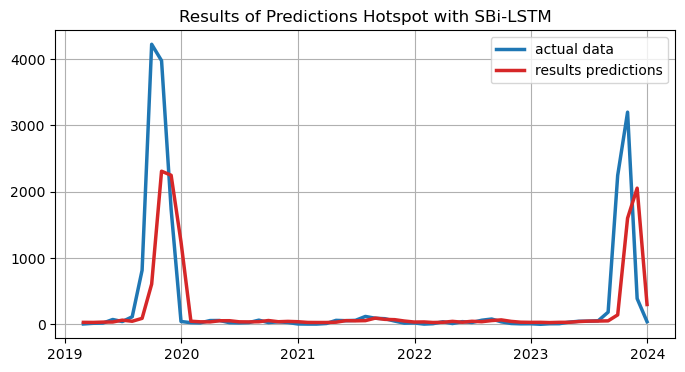

In [15]:
# show result predictions
lineplot3(
  x1=dataset["acq_date"].iloc[len(train_data)+1:], y1=inverse(scaler,y_test.reshape(-1,1)), label1="actual data",
  x2=dataset["acq_date"].iloc[len(train_data)+1:], y2=inverse(scaler,lstm_predictions.reshape(-1,1)), label2="results predictions",
  title="Results of Predictions Hotspot with SBi-LSTM"
)

In [16]:
# process evaluate models
r, p, mae, rmse, mape = evaluate_models(
  ytrue=inverse(scaler, y_test.reshape(-1,1)),
  ypred=inverse(scaler, lstm_predictions.reshape(-1,1)),
)

# results evaluate models
print("R       : "+str(r))
print("P-value : "+str(p))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape*100))

R       : 0.6488
P-value : 0.0
MAE     : 245.146
RMSE    : 687.8788
MAPE    : 173.57


#### 5.2 SBi-LSTM-XGBoost

In [17]:
# call models XGBoost
xgb_predictions = get_XGBoost(
  xtrue=x_test, ytrue=y_test, ypred=lstm_predictions
)

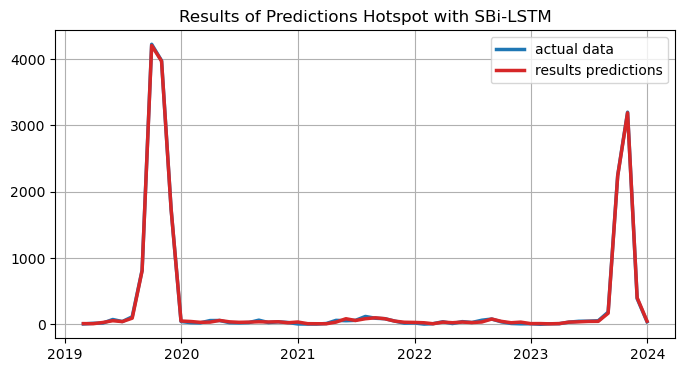

In [18]:
# show result predictions
lineplot3(
  x1=dataset["acq_date"].iloc[len(train_data)+1:], y1=inverse(scaler, y_test.reshape(-1,1)), label1="actual data",
  x2=dataset["acq_date"].iloc[len(train_data)+1:], y2=inverse(scaler, xgb_predictions.reshape(-1,1)), label2="results predictions",
  title="Results of Predictions Hotspot with SBi-LSTM"
)

In [19]:
# process evaluate models
r, p, mae, rmse, mape = evaluate_models(
  ytrue=inverse(scaler, y_test.reshape(-1,1)),
  ypred=inverse(scaler, xgb_predictions.reshape(-1,1)),
)

# results evaluate models
print("R       : "+str(r))
print("P-value : "+str(p))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape))

R       : 0.9999
P-value : 0.0
MAE     : 10.08
RMSE    : 13.3095
MAPE    : 0.4541


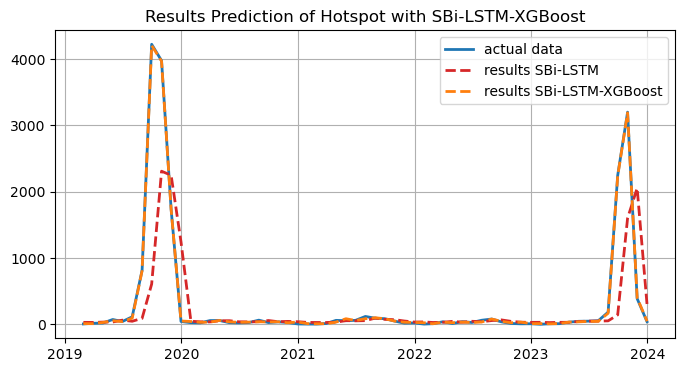

In [20]:
# show result predictions
lineplot4(

  # sumbu x
  date=dataset["acq_date"].iloc[len(train_data)+1:],
  
  # data actual
  ytrue=inverse(scaler, y_test.reshape(-1,1)),

  # hasil SBi-LSTM
  ypred1=inverse(scaler, lstm_predictions.reshape(-1,1)),
  label1="results SBi-LSTM",
  
  # hasil SBi-LSTM-XGBoost
  ypred2=inverse(scaler, xgb_predictions.reshape(-1,1)),
  label2="results SBi-LSTM-XGBoost",

  # title plot
  title="Results Prediction of Hotspot with SBi-LSTM-XGBoost"
)

### 6. Algoritma GRU-RNN

#### 6.1 SBi-GRU-RNN

In [21]:
# call models GRU
# param : algorithm, timestep, activation, optimizer, dropout
gru_model = get_models_univariate(
  algorithm="SBi-GRU", timestep=x_train, activation="selu", optimizer="sgd", dropout=0.25
)

In [22]:
# compile models
# param : model, batch_size, epochs, x_train, y_train, x_test, y_test
gru_history, gru_predictions = get_prediction(
  model=gru_model, batch_size=4, epochs=1500, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

Epoch 1/1500
54/54 [==============================] - 7s 16ms/step - loss: 0.2826 - val_loss: 0.0915
Epoch 2/1500
54/54 [==============================] - 0s 3ms/step - loss: 0.1208 - val_loss: 0.0654
Epoch 3/1500
54/54 [==============================] - 0s 4ms/step - loss: 0.1184 - val_loss: 0.0355
Epoch 4/1500
54/54 [==============================] - 0s 4ms/step - loss: 0.1218 - val_loss: 0.0381
Epoch 5/1500
54/54 [==============================] - 0s 4ms/step - loss: 0.1144 - val_loss: 0.0864
Epoch 6/1500
54/54 [==============================] - 0s 4ms/step - loss: 0.1102 - val_loss: 0.0352
Epoch 7/1500
54/54 [==============================] - 0s 4ms/step - loss: 0.1093 - val_loss: 0.0666
Epoch 8/1500
54/54 [==============================] - 0s 4ms/step - loss: 0.1090 - val_loss: 0.0431
Epoch 9/1500
54/54 [==============================] - 0s 4ms/step - loss: 0.1051 - val_loss: 0.0434
Epoch 10/1500
54/54 [==============================] - 0s 4ms/step - loss: 0.0984 - val_loss: 0.035

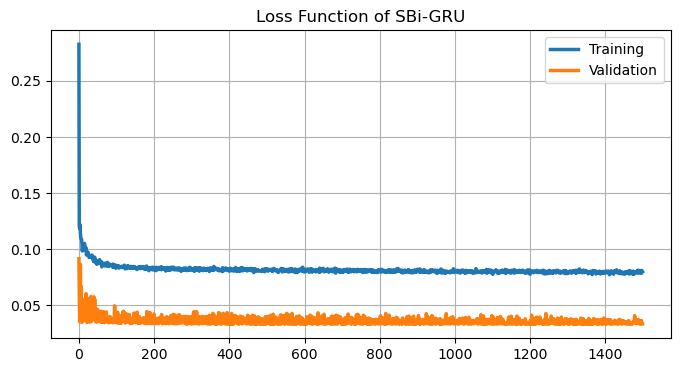

In [23]:
# show loss function
lineplot2(
  x1=gru_history.epoch, y1=gru_history.history['loss'], label1="Training",
  x2=gru_history.epoch, y2=gru_history.history['val_loss'], label2="Validation",
  title="Loss Function of SBi-GRU"
)

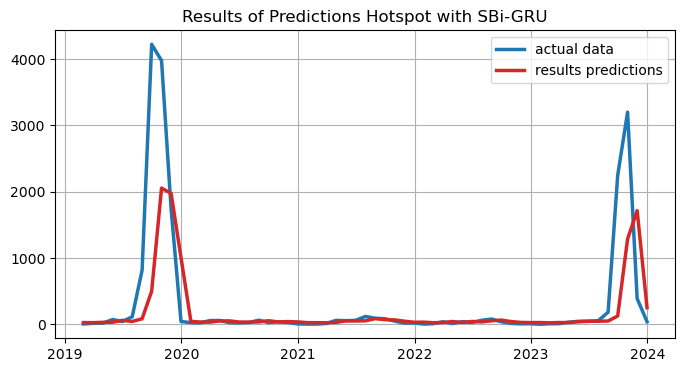

In [24]:
# show result predictions
lineplot3(
  x1=dataset["acq_date"].iloc[len(train_data)+1:], y1=inverse(scaler,y_test.reshape(-1,1)), label1="actual data",
  x2=dataset["acq_date"].iloc[len(train_data)+1:], y2=inverse(scaler,gru_predictions.reshape(-1,1)), label2="results predictions",
  title="Results of Predictions Hotspot with SBi-GRU"
)

In [25]:
# process evaluate models
r, p, mae, rmse, mape = evaluate_models(
  ytrue=inverse(scaler, y_test.reshape(-1,1)),
  ypred=inverse(scaler, gru_predictions.reshape(-1,1)),
)

# results evaluate models
print("R       : "+str(r))
print("P-value : "+str(p))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape*100))


R       : 0.6501
P-value : 0.0
MAE     : 241.2532
RMSE    : 701.756
MAPE    : 150.32000000000002


#### 6.1 SBi-GRU-XGBoost

In [26]:
# call models XGBoost
xgb_predictions = get_XGBoost(
  xtrue=x_test,
  ytrue=y_test,
  ypred=gru_predictions
)

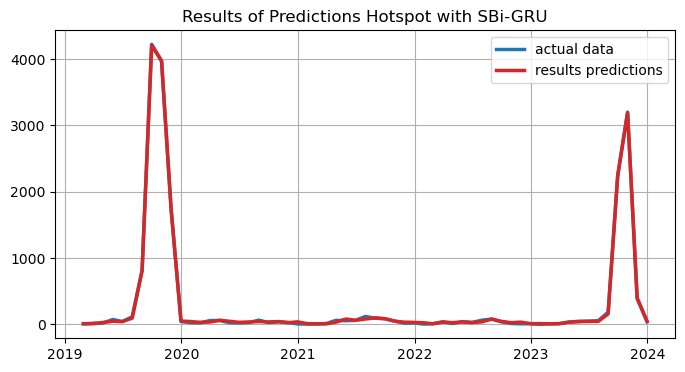

In [27]:
# show result predictions
lineplot3(
  x1=dataset["acq_date"].iloc[len(train_data)+1:], y1=inverse(scaler, y_test.reshape(-1,1)), label1="actual data",
  x2=dataset["acq_date"].iloc[len(train_data)+1:], y2=inverse(scaler, xgb_predictions.reshape(-1,1)), label2="results predictions",
  title="Results of Predictions Hotspot with SBi-GRU"
)

In [28]:
# process evaluate models
r, p, mae, rmse, mape = evaluate_models(
  ytrue=inverse(scaler, y_test.reshape(-1,1)),
  ypred=inverse(scaler, xgb_predictions.reshape(-1,1)),
)

# results evaluate models
print("R       : "+str(r))
print("P-value : "+str(p))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape))

R       : 0.9999
P-value : 0.0
MAE     : 10.5208
RMSE    : 13.9271
MAPE    : 0.4643


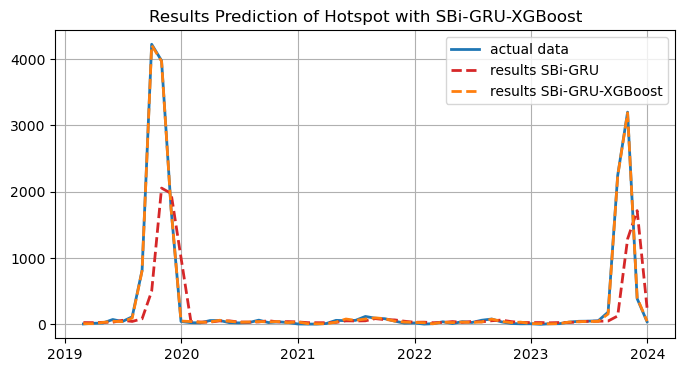

In [29]:
# show result predictions
lineplot4(

  # sumbu x
  date=dataset["acq_date"].iloc[len(train_data)+1:],
  
  # data actual
  ytrue=inverse(scaler, y_test.reshape(-1,1)),

  # hasil SBi-GRU
  ypred1=inverse(scaler, gru_predictions.reshape(-1,1)),
  label1="results SBi-GRU",
  
  # hasil SBi-GRU-XGBoost
  ypred2=inverse(scaler, xgb_predictions.reshape(-1,1)),
  label2="results SBi-GRU-XGBoost",

  # title plot
  title="Results Prediction of Hotspot with SBi-GRU-XGBoost"
)